In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from families import family_from_str
from efn_util import setup_IO
from plot_util import get_latest_diagnostics, find_last_ind
from efn_util import find_convergence
import seaborn as sns

basedir = '/Users/sbittner/Documents/efn/';
colors = ["dusty purple", "pale red", "windows blue", "medium green", "amber", "greyish", "faded green", "denim blue"];
palette = sns.xkcd_palette(colors)

exp_fam = 'dir_dir';
give_hint = (exp_fam == 'normal' or exp_fam == 'inv_wishart');
D = 4;
K = 100;
M = 1000;
param_net_hps = {'L':4};
stochastic_eta = True;


fam_class = family_from_str(exp_fam);
family = fam_class(D);

if (exp_fam == 'dirichlet' or exp_fam == 'dir_mult' or exp_fam == 'dir_dir'):
    TIF_flow_types = ['PlanarFlowLayer', \
                    'StructuredSpinnerTanhLayer', 'AffineFlowLayer'];
    nlayers = [D, D, 1];
elif (exp_fam == 'normal'):
    TIF_flow_types = ['PlanarFlowLayer', 'RadialFlowLayer', \
                    'StructuredSpinnerTanhLayer', 'AffineFlowLayer'];
    nlayers = [D, D, D, 1];
elif (exp_fam == 'inv_wishart'):
    TIF_flow_types = ['PlanarFlowLayer', 'RadialFlowLayer', \
                     'AffineFlowLayer'];
    nlayers = [D, D, 1];
print(TIF_flow_types);
num_archs = len(TIF_flow_types);
num_rs = 5;

wsize = 50;
delta_thresh = 1e-10;

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['PlanarFlowLayer', 'StructuredSpinnerTanhLayer', 'AffineFlowLayer']


In [20]:
diagnostic_list = [];
for i in range(num_archs):
    color = palette[i];
    elbos_by_rs = np.zeros((num_rs, K));
    R2s_by_rs = np.zeros((num_rs, K));
    KLs_by_rs = np.zeros((num_rs, K));
    for j in range(num_rs):
        random_seed = j;
        TIF_flow_type = TIF_flow_types[i];
        flow_dict = {'latent_dynamics':None, \
                     'TIF_flow_type':TIF_flow_type, \
                     'repeats':nlayers[i]};
        savedir = basedir + setup_IO(family, 'EFN', 'eta', K, M, flow_dict, \
                                      param_net_hps, stochastic_eta, give_hint, random_seed);
        fname = savedir + 'results.npz';
        
        try:
            npzfile = np.load(fname);
        except:
            print('issue reading %s' % fname);
            continue
        
        test_elbos = npzfile['test_elbos'];
        last_ind = find_last_ind(test_elbos);
        mean_test_elbos = np.mean(test_elbos, 1);
        ind = find_convergence(mean_test_elbos, last_ind+1, wsize, delta_thresh);
        if (ind is None):
            print('Hasnt converged: %s' % fname);
            continue;
        elbos, R2s, KLs, status = get_latest_diagnostics(fname, is_train=False);
        
        elbos_by_rs[j,:] = elbos;
        R2s_by_rs[j,:] = R2s;
        KLs_by_rs[j,:] = KLs;
    diagnostic_list.append([elbos_by_rs, R2s_by_rs, KLs_by_rs]);
    
random_seeds = [0,1,2,3,4];



issue reading /Users/sbittner/Documents/efn/results/June/tb/EFN_hierarchical_dirichlet_stochasticEta_D=4_K=100_M=1000_flow=4S_L=4_rs=0/results.npz
issue reading /Users/sbittner/Documents/efn/results/June/tb/EFN_hierarchical_dirichlet_stochasticEta_D=4_K=100_M=1000_flow=4S_L=4_rs=1/results.npz
issue reading /Users/sbittner/Documents/efn/results/June/tb/EFN_hierarchical_dirichlet_stochasticEta_D=4_K=100_M=1000_flow=4S_L=4_rs=2/results.npz
issue reading /Users/sbittner/Documents/efn/results/June/tb/EFN_hierarchical_dirichlet_stochasticEta_D=4_K=100_M=1000_flow=4S_L=4_rs=3/results.npz
issue reading /Users/sbittner/Documents/efn/results/June/tb/EFN_hierarchical_dirichlet_stochasticEta_D=4_K=100_M=1000_flow=4S_L=4_rs=4/results.npz


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sbittner/Library/Python/3.6/lib/python/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


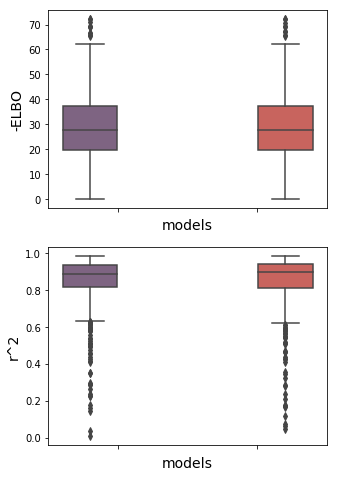

In [21]:
from plot_util import EFN_model_df
fontsize = 14;
df = EFN_model_df('models',TIF_flow_types,'random_seeds', random_seeds, diagnostic_list);

plt.figure(figsize=(5,8));
#plt.subplot(3,1,1);
#ax = sns.boxplot(x='models', y='KL', hue='models', \
#                  data=df, palette=palette);
#ax.set_xticklabels([]);
#ax.set_xlabel('models', fontsize=fontsize);
#ax.set_ylabel('KL', fontsize=fontsize);


plt.subplot(2,1,1);
ax = sns.boxplot(x='models', y='elbo', hue='models', \
                  data=df, palette=palette);
ax.set_xticklabels([]);
ax.set_xlabel('models', fontsize=fontsize);
ax.set_ylabel('-ELBO', fontsize=fontsize);
ax.legend_.remove();

plt.subplot(2,1,2);
ax = sns.boxplot(x='models', y='R2', hue='models', \
                  data=df, palette=palette);
ax.set_xticklabels([]);
ax.set_xlabel('models', fontsize=fontsize);
ax.set_ylabel('r^2', fontsize=fontsize);
ax.legend_.remove();

plt.show();


In [22]:
print('flow   <KL>     <ELBO>      <R2>');
for i in range(num_archs):
    flow_type = TIF_flow_types[i];
    inds = df['models']==flow_type;
    KLs = df['KL'][inds];
    elbos = df['elbo'][inds];
    R2s = dsf['R2'][inds];
    print('%s      %.2f     %.2f       %.2f' % (flow_type[0], np.mean(KLs), np.mean(elbos), np.mean(R2s)));

flow   <KL>     <ELBO>      <R2>
P      nan     29.10       0.84
S      nan     nan       nan
A      nan     29.07       0.84


In [23]:
"""
plt.figure();
for i in range(num_archs):
    color = palette[i];
    for j in range(num_rs):
        random_seed = j;
        TIF_flow_type = TIF_flow_types[i];
        flow_dict = {'latent_dynamics':None, \
                     'TIF_flow_type':TIF_flow_type, \
                     'repeats':nlayers[i]};
        modeldir = setup_IO(family, 'EFN', 'eta', K, M, flow_dict, \
                                      param_net_hps, stochastic_eta, give_hint, random_seed);
        print(family.name);
        savedir = basedir + modeldir;
        fname = savedir + 'results.npz';
        try:
            npzfile = np.load(fname);
        except:
            print('issue reading %s' % modeldir);
            continue
        check_rate = npzfile['check_rate'];
        test_elbos = npzfile['test_elbos'];
        test_R2s = npzfile['test_R2s'];
        
        mean_test_R2s = np.mean(test_R2s, 1);   
        mean_test_elbos = np.mean(test_elbos, 1);
        last_ind = find_last_ind(test_elbos);
        
        ind = find_convergence(mean_test_elbos, last_ind+1, wsize, delta_thresh);
    
        if (ind is not None):
            iterations = np.arange(0, check_rate*(ind+1), check_rate);
            plt.plot(iterations, mean_test_elbos[:(ind+1)], color=color);
        else:
            ind = mean_test_elbos.shape[0];
            print('Hasnt converged: %s' % fname);
            iterations = np.arange(0, check_rate*(ind), check_rate);
            plt.plot(iterations, mean_test_elbos, color=color);
        #plt.show();
plt.show();
"""

"\nplt.figure();\nfor i in range(num_archs):\n    color = palette[i];\n    for j in range(num_rs):\n        random_seed = j;\n        TIF_flow_type = TIF_flow_types[i];\n        flow_dict = {'latent_dynamics':None,                      'TIF_flow_type':TIF_flow_type,                      'repeats':nlayers[i]};\n        modeldir = setup_IO(family, 'EFN', 'eta', K, M, flow_dict,                                       param_net_hps, stochastic_eta, give_hint, random_seed);\n        print(family.name);\n        savedir = basedir + modeldir;\n        fname = savedir + 'results.npz';\n        try:\n            npzfile = np.load(fname);\n        except:\n            print('issue reading %s' % modeldir);\n            continue\n        check_rate = npzfile['check_rate'];\n        test_elbos = npzfile['test_elbos'];\n        test_R2s = npzfile['test_R2s'];\n        \n        mean_test_R2s = np.mean(test_R2s, 1);   \n        mean_test_elbos = np.mean(test_elbos, 1);\n        last_ind = find_last_in